In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import requests
from PIL import Image
import football_pitch as pitch
from py_medoids import XMedoids, GMedoids

colors = [
    (1.0, 0.0, 0.0, 0.8), (0.0, 1.0, 0.0, 0.8), (0.0, 0.0, 1.0, 0.8),
    (1.0, 1.0, 0.0, 0.8), (1.0, 0.0, 1.0, 0.8), (0.0, 1.0, 1.0, 0.8),
    (0.5, 0.0, 0.0, 0.8), (0.0, 0.5, 0.0, 0.8), (0.0, 0.0, 0.5, 0.8),
    (1.0, 0.5, 0.0, 0.8), (0.0, 1.0, 0.5, 0.8), (0.5, 0.0, 1.0, 0.8),
    (1.0, 0.0, 0.5, 0.8), (0.5, 1.0, 0.0, 0.8), (0.0, 0.5, 1.0, 0.8),
]
im = Image.open("TH433.png").convert('P')

In [2]:
# zonal pass cluster map with statsbomb

base_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
comp_url = base_url + "matches/{}/{}.json"
match_url = base_url + "events/{}.json"
features = ['x', 'y', 'end_x', 'end_y']
match_id = 7541

events = requests.get(url=match_url.format(match_id)).json()
passes = [x for x in events if x['type']['name'] == "Pass"]
all_events = []
for p in passes:
    attributes = {
        "x": p['location'][0],
        "y": p['location'][1],
        "end_x": p['pass']['end_location'][0],
        "end_y": p['pass']['end_location'][1],
        "outcome": 0 if 'outcome' in p['pass'].keys() else 1,
        "team": p['team']['name'],
        "player": p['player']['name'],
    }
    all_events.append(attributes)
            
pd_events = pd.DataFrame(all_events)

home_team = events[0]['team']['name']
home_players = [x['player']['name'] for x in events[0]['tactics']['lineup']]
away_team = events[1]['team']['name']
away_players = [x['player']['name'] for x in events[1]['tactics']['lineup']]

home_away = False
if home_away:
    selected_players = home_players
    selected_team = home_team
else:
    selected_players = away_players
    selected_team = away_team

/home/faintliongabbing/py_medoids.py:409: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.cov = np.cov(self.data.T)
/home/faintliongabbing/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/faintliongabbing/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/faintliongabbing/py_medoids.py:409: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.cov = np.cov(self.data.T)
/home/faintliongabbing/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/faintliongabbing/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


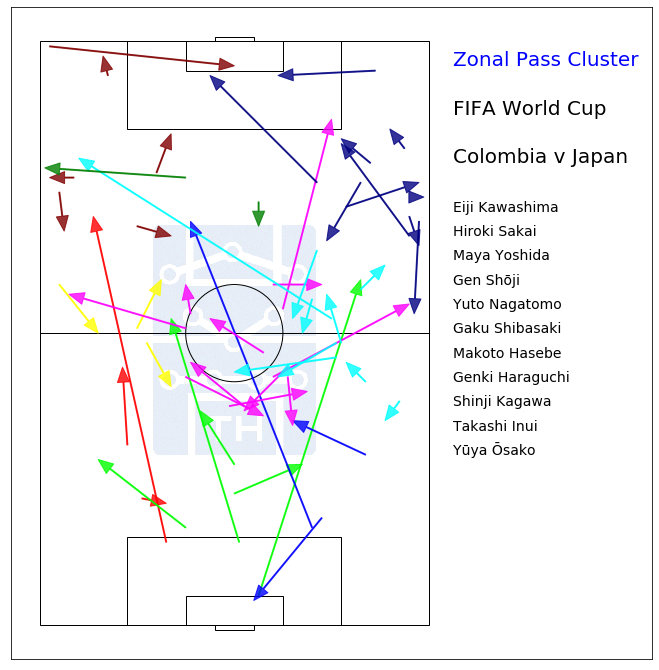

In [3]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.set_xticks([])
ax.set_yticks([])

for i in range(3):
    pd_events_i = pd_events.query(str(i * 40) + ' <= x <= ' + str((i + 1) * 40))
    pd_events_i = pd_events_i[pd_events_i.team == selected_team]
    for j in range(3):
        pd_events_ij = pd_events_i.query(str(j * 26.7) + ' <= y <= ' + str((j + 1) * 26.7))
        if len(pd_events_ij) < 15:
            continue
        # pred_ij = XMedoids(n_cluster=2, max_iter=300).fit(pd_events_ij[features[0:4]])
        pred_ij = GMedoids(n_cluster=2, max_iter=300).fit(pd_events_ij[features[0:4]])
        for row in pred_ij.cluster_centers_:
            pitch.arrow(ax, row[1]-40, row[0]-60, row[3]-40, row[2]-60, 1, colors[i * 3 + j])
        pd_events_ij = None
    pd_events_i = None

i = 0
for player in selected_players:
    plt.text(45, 25-i*5, player, fontsize=14, color='black')
    i += 1

pitch.soccer_pitch_v(ax)
plt.text(45, 55, "Zonal Pass Cluster", fontsize=20, color='blue')
plt.text(45, 45, 'FIFA World Cup', fontsize=20, color='black')
plt.text(45, 35, home_team + ' v ' + away_team, fontsize=20, color='black')

extent = [-30, 30, -30, 30]
ax.imshow(im, alpha=0.1, extent=extent)
plt.show()